In [1]:
import scipy.stats as st 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
from patsy import dmatrices
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

In [3]:
import pymc3 as pm
from pymc3 import Normal, Binomial, sample, Model # Import relevant distributions
from pymc3.math import invlogit
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

C:\Users\hvill\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Simulate Data (Logistic Regression)

In [152]:
## TOY DATA LOGISTIC Regression
#> set.seed(666)
np.random.seed(seed=233423)
x1 = st.norm.rvs(size=10000)           # some continuous variables 
x2 = st.norm.rvs(size=10000)  
z = 1 + 2 *x1 +3 *x2        # linear combination with a bias
pr = 1/(1 +np.exp(-z))         # pass through an inv-logit function
y = st.binom.rvs(n=1,p=pr, size=10000) #rbinom(1000,1,pr) # bernoulli response variable
 
X=np.column_stack([x1,x2])
# standardize the features since regularization requires all features to be on same scale
scaler = StandardScaler(copy=True)
# we have created a standardization based on the training data
X_train, X_test, y_train, y_test = train_test_split(scaler.fit(X).transform(X), y, test_size=0.33, random_state=42)

#now feed it to glm:
#df = data.frame(y=y,x1=x1,x2=x2)

# XGBOOST

In [153]:
u=xgb.XGBClassifier()

u.set_params( learning_rate= 0.1, max_depth= 4, n_estimators= 5 )
u.fit(X_train, y_train)

print('u.feature_importances_',u.feature_importances_)
cross_val_score(u, X_train, y_train, cv=10 ).mean()

# Logistic Regression

u.feature_importances_ [ 0.58108109  0.41891891]


0.85223806817828562

In [177]:
u.booster().get_score(importance_type='cover')

{'f0': 336.2849116279069, 'f1': 575.6274193548386}

#### Importance type can be defined as:
- 'weight' - the number of times a feature is used to split the data across all trees.
- 'gain' - the average gain of the feature when it is used in trees
- 'cover' - the average coverage of the feature when it is used in trees

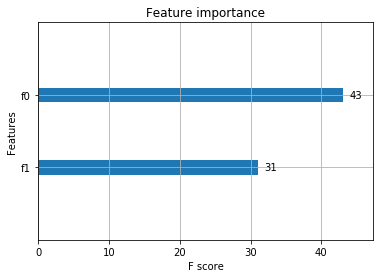

In [178]:
xgb.plot_importance(u,importance_type="weight")

In [293]:
#COVER
p = u.predict_proba( X_train, ntree_limit=0)
print(len(p)*sum(np.repeat(0.5,len(p))*(1-np.repeat(0.5,len(FF)))))  # sum of the hessians in that node,(root node has all data)
FF = pd.DataFrame(X_train)
FF['y'] =y_train
FF['Prob0'] = pd.DataFrame(p)[0]
FF['Prob1'] = pd.DataFrame(p)[1]
#next node
sum(np.array(FF[FF[1]<-0.225163][['Prob0','Prob1']])*(1-np.array(FF[FF[1]<-0.225163][['Prob0','Prob1']])))

11222500.0


array([ 638.65863037,  638.65863037], dtype=float32)

In [180]:
u.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [181]:
results = u.booster().get_dump( with_stats=True)

In [189]:
#First Tree
for tree in [results[0]]:
    for line in tree.split('\n'):
        #if  'leaf=' in line:
        print(line)
        #print(line)
        if '3:[' in line:
            break

0:[f1<-0.225163] yes=1,no=2,missing=1,gain=1853.31,cover=1675
	1:[f0<0.304833] yes=3,no=4,missing=3,gain=486.058,cover=694
		3:[f1<-0.645459] yes=7,no=8,missing=7,gain=57.4649,cover=442.25


In [191]:
##### Gain for first tree
z = 0.5
nn= -0.225163
p = np.repeat(z,len(FF))
#2783
# L = which(X[,'odor=none']==0) 
# R = which(X[,'odor=none']==1)

pL = np.repeat(z,len(FF[FF[1]<nn]['y'])) #p[FF[1]<-0.324049]
pR = np.repeat(z,len(FF[FF[1]>=nn]['y'])) #p[FF[1]>= -0.324049]

yL = FF[FF[1]<nn]['y']
yR = FF[FF[1]>=nn]['y']

GL = sum(pL-yL)
GR = sum(pR-yR)
G = sum(p-np.array(FF['y']))
#G = sum(np.array(FF['Prob1'])-np.array(FF['y']))

HL = sum(pL*(1-pL))
HR = sum(pR*(1-pR))
H = sum(p*(1-p))

gain = 0.5*((GL**2/(HL+1))+(GR**2/(HR+1))-(G**2/(H+1)))
print(round(gain*2,2))

1853.31


In [193]:
#Next tree
tt = u.predict_proba(X_train,output_margin=False,ntree_limit=1)
FF1 = pd.DataFrame(X_train)
FF1['Prob0'] = pd.DataFrame(tt)[0]
FF1['Prob1'] = pd.DataFrame(tt)[1]
FF1['y'] =y_train
FF1.head()

,0,1,Prob0,Prob1,y
0,0.545257,-0.653484,0.495375,0.504625,0
1,-0.332258,1.866386,0.451967,0.548033,1
2,1.227723,-0.269642,0.466756,0.533244,1
3,-0.006776,-0.993703,0.538894,0.461106,0
4,-1.202238,0.914339,0.463489,0.536511,1


In [197]:
#Second Tree
for tree in [results[1]]:
    for line in tree.split('\n'):
        #if  'leaf=' in line:
        print(line)
        #print(line)
        if '3:[' in line:
            break

0:[f1<-0.225163] yes=1,no=2,missing=1,gain=1512.82,cover=1665.44
	1:[f0<0.304833] yes=3,no=4,missing=3,gain=397.685,cover=690.434
		3:[f1<-0.645459] yes=7,no=8,missing=7,gain=47.6899,cover=439.491


In [198]:
########  GAIN of 2nd tree
#Using prior trees probabilty Calculate the new G and H

nn= -0.225163
p = FF1['Prob1']

pL = FF1[FF1[1]<nn]['Prob1']
pR = FF1[FF1[1]>=nn]['Prob1']

yL = FF1[FF1[1]<nn]['y']
yR = FF1[FF1[1]>=nn]['y']

GL = sum(pL-yL)
GR = sum(pR-yR)
G = sum(p-np.array(FF1['y']))

HL = sum(pL*(1-pL))
HR = sum(pR*(1-pR))
H = sum(p*(1-p))

gain = 0.5*((GL**2/(HL+1))+(GR**2/(HR+1))-(G**2/(H+1)))
print(round(gain*2,2))

1512.82


In [199]:
###  XGBOOST RESOURCES

#https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf
#https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated/33614843
# https://chaoticsenses.wordpress.com/2015/09/20/xgboost-a-macroscopic-anatomy/
# http://www.grroups.com/blog/an-information-gain-based-feature-ranking-function-for-xgboost
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# https://cran.r-project.org/web/packages/xgboost/xgboost.pdf
# https://machinelearningmastery.com/xgboost-python-mini-course/
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# https://stats.stackexchange.com/questions/231220/
# how-to-compute-the-gradient-and-hessian-of-logarithmic-loss-question-is-based/231270
# https://arxiv.org/pdf/1603.02754.pdf
# https://arxiv.org/pdf/1606.05390.pdf
# https://jessesw.com/XG-Boost/
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://datascience.stackexchange.com/questions/12318/how-do-i-interpret-the-output-of-xgboost-importance
# https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated

In [200]:
#### Calculate GAIN or COVER for the entire Model (ALL TREES)
importance_type = 'gain' #'cover'
importance_type += '='
fmap = {}
gmap = {}
for tree in results:
    for line in tree.split('\n'):
        # look for the opening square bracket
        arr = line.split('[')
        #print('arr: ',arr, len(arr))
        # if no opening bracket (leaf node), ignore this line
        if len(arr) == 1:
            #print('arr: ',arr, len(arr))
            continue

        # look for the closing bracket, extract only info within that bracket
        fid = arr[1].split(']')
        #print('fid] : ',fid)
        # extract gain or cover from string after closing bracket
        g = float(fid[1].split(importance_type)[1].split(',')[0])
        #print('g: ',g)
        # extract feature name from string before closing bracket
        fid = fid[0].split('<')[0]
        #print('fid< : ',fid)

        if fid not in fmap:
            # if the feature hasn't been seen yet
            fmap[fid] = 1
            gmap[fid] = g
        else:
            fmap[fid] += 1
            gmap[fid] += g

# calculate average value (gain/cover) for each feature
for fid in gmap:
    gmap[fid] = gmap[fid] / fmap[fid]

print(fmap,gmap,importance_type)

{'f1': 31, 'f0': 43} {'f1': 286.6727258064515, 'f0': 98.5243472883721} gain=


In [166]:
######  Calculate WEIGHT for the entire Model (ALL TREES)
fmap={}
for tree in [results[0]]:
    for line in tree.split('\n'):
        # look for the opening square bracket
        arr = line.split('[')
        #print('arr :',arr,"len(arr) == 1 : ",len(arr) == 1,len(arr))
                    # if no opening bracket (leaf node), ignore this line
        if len(arr) == 1:
            #print(len(arr) == 1,'arr :',arr)
            continue
        # extract feature name from string between []
        fid = arr[1].split(']')[0].split('<')[0]
        #print('fid :',fid)
        if fid not in fmap:
        # if the feature hasn't been seen yet
            fmap[fid] = 1
        else:
            fmap[fid] += 1
print('Weight',fmap)

Weight {'f1': 6, 'f0': 9}


In [201]:
u.booster().get_split_value_histogram('f1')

,SplitValue,Count
0,-1.249088,2.0
1,-1.141577,1.0
2,-1.034065,1.0
3,-0.926553,1.0
4,-0.711530,4.0
5,-0.604018,2.0
6,-0.496506,1.0
7,-0.388994,2.0
8,-0.281483,1.0
9,-0.173971,2.0


In [202]:
pd.DataFrame(u.feature_importances_, columns=['weights'])

,weights
0,0.581081
1,0.418919


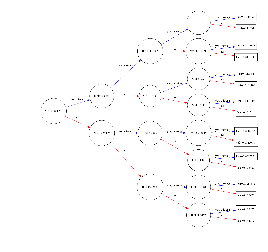

In [203]:
xgb.plot_tree(u, num_trees=4, rankdir='LR') 

In [206]:
def order_features_by_gains(bst, feature_map_file=None):
    str_dump = bst.booster().get_dump(with_stats=True)
    
    tree_arr = []
    for i_tree, tree in enumerate(str_dump):
        arr_lvls=tree.split('\n\t')
        a_tree = {}
        for lvl in arr_lvls:
            a_lvl ={}
            dum1 = lvl.split(',')
            if('leaf' in lvl):
                dum1[0].replace('\t','')
                dum10 = dum1[0].split(':')
                lvl_id = int(dum10[0])
                dum11 = dum10[1].split('leaf=')
                leaf = float(dum11[1])
                
                cover = float(dum1[1].replace('\n','').split('cover=')[1])
                a_lvl['lvl_id']=lvl_id
                a_lvl['leaf']=leaf
                a_lvl['cover']=cover
            else:
                dum10 = dum1[0].replace('\t','').replace('\n','')
                dum11 = dum10.split(':')
                lvl_id = int(dum11[0])
                dum12 = dum11[1].split('yes=')
                dum13 = dum12[0].replace('[','').replace(']','').split('<')
                feat_name = dum13[0]
                
                yes_to = int(dum12[1])
                no_to = int(dum1[1].split('no=')[1])
                missing = int(dum1[2].split('missing=')[1])
                gain = float(dum1[3].split('gain=')[1])
                cover = float(dum1[4].split('cover=')[1])            
                feat_thr = float(dum12[1])
                
                a_lvl['lvl_id']=lvl_id
                a_lvl['feat_name']=feat_name
                a_lvl['feat_thr'] = feat_thr
                a_lvl['yes_to'] = yes_to
                a_lvl['no_to']=no_to
                a_lvl['missing'] = missing
                a_lvl['gain']=gain
                a_lvl['cover']=cover
                
            a_tree[str(lvl_id)] = a_lvl
        tree_arr.append(a_tree)    
    feat_vocabulary = {}
    for tree in tree_arr:
        for lvl in tree:
            if('gain' in tree[lvl]):
                feat_data = feat_vocabulary.setdefault(tree[lvl]['feat_name'],\
                                                       {'gain':tree[lvl]['gain'],'cover':tree[lvl]['cover']})
                if(feat_data!={'gain':tree[lvl]['gain'],'cover':tree[lvl]['cover']}):
                    try:
                        feat_vocabulary[tree[lvl]['feat_name']]['gain'] += tree[lvl]['gain']                    
                        feat_vocabulary[tree[lvl]['feat_name']]['cover'] += tree[lvl]['cover']
                    except:
                        feat_vocabulary[tree[lvl]['feat_name']]['gain'] = tree[lvl]['gain']                    
                        feat_vocabulary[tree[lvl]['feat_name']]['cover'] = tree[lvl]['cover']          
    
    sorted_feats = sorted(feat_vocabulary.items(),key=lambda k:k[1]['gain'], reverse=True)
    return sorted_feats

In [207]:
order_features_by_gains(u)

[('f1', {'cover': 17844.449999999997, 'gain': 8886.8545}),
 ('f0', {'cover': 14460.2512, 'gain': 4236.546933399999})]

# Simulate Data (Logistic Regression)

In [208]:
## TOY DATA LOGISTIC Regression

np.random.seed(seed=233423)
x1 = st.norm.rvs(size=10000)           # some continuous variables 
x2 = st.norm.rvs(size=10000)  
z = 1 + 2 *x1 +3 *x2        # linear combination with a bias
pr = 1/(1 +np.exp(-z))         # pass through an inv-logit function
y = st.binom.rvs(n=1,p=pr, size=10000) #rbinom(1000,1,pr) # bernoulli response variable
 
X=np.column_stack([x1,x2])
# standardize the features since regularization requires all features to be on same scale
scaler = StandardScaler(copy=True)
# we have created a standardization based on the training data
X_train, X_test, y_train, y_test = train_test_split(scaler.fit(X).transform(X), y, test_size=0.33, random_state=42)

# XGBOOST

In [174]:
model=xgb.XGBClassifier()

In [211]:
learning_rate=[0.0001,0.001,0.01,0.1,0.2,0.3]
n_estimators=[50,100,150,200]
max_depth=[2,4,6,8]
param_grid=dict(learning_rate=learning_rate,max_depth=max_depth,n_estimators=n_estimators)
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
grid_search=GridSearchCV(model,param_grid,n_jobs=-1,cv=kfold)
#grid_result=grid_search.fit(X,y)
grid_result=grid_search.fit(X_train,y_train)

In [212]:
#Take forever
cross_val_score(grid_result, X_train, y_train, cv=3 )

array([ 0.85452104,  0.85982983,  0.85490372])

# Logistic Regression

- Logistic Regression Bayesian Inference approach :
    - Pymc3 with Theano

    Steps:
        1. Prepare Data
        2. Build Probabilistic Model
        3. Condition Model on Data & Find the local maximum a posteriori point given a model (MAP)
        4. Sample posterior distribution using MAP as starting points for Indepedent Variables(X's)
        5. Generate posterior predictive samples from model given a Samples of posterior distribution.

In [ ]:
# 1 Use theano shared variable so that we can make predictions for new values later
log_dose_shared0 = shared(X_train[:, 0])
log_dose_shared = shared(X_train[:, 1])

# Sample size in each group. The sample size has to be a shared variable too
# Each row/observation is a group so n = total in group. 1 if only one per group
n_shared = shared(np.ones(len(X_train), dtype=int))

# Outcomes/Target
deaths = y_train


# 2 Build Probabilistic Model
with Model() as bioassay_model:

    # Priors for unknown model parameters. e.g. Logit-linear model parameters
    alpha = Normal('alpha', 0, sd=100)
    beta = Normal('beta', 0, sd=100)
    beta0 = Normal('beta0', 0, sd=100)

    # Expected value of outcome. e.g. link function outcome. Calculate probabilities of Y/Target
    theta = invlogit(alpha + beta * log_dose_shared + beta0 * log_dose_shared0 )

    # Likelihood (sampling distribution) of observations Data likelihood YTarget
    obs_deaths = Binomial('obs_deaths', n=n_shared, p=theta, observed=deaths)

    
# 3 Finds the local maximum a posteriori point given a model. uses BFGS.
from pymc3 import find_MAP
# Runs fit to data returns parameters/coefficients
map_estimate = find_MAP(model=bioassay_model)
print(map_estimate)


# 4 Now draw samples from the posterior using the given step methods.
with bioassay_model:
    
    # obtain starting values via MAP
    start = find_MAP(model=bioassay_model)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    # posterior of X's
    # draw 1,000 posterior samples of independent variables
    bioassay_trace = sample(1000, step=step, start=start)


# 5 Generate posterior predictive samples from a model given a trace.
from pymc3 import sample_ppc

with bioassay_model:
    deaths_sim = sample_ppc(bioassay_trace, samples=1000)
    
# take only last half  of posterior distr. of X's. other half was burn in.
tr1 = bioassay_trace[500:]
    
#PREDICT
log_dose_to_predict0 = X_train[:1000,0] #np.random.uniform(-0.8,0.7,size=50)
log_dose_to_predict = X_train[:1000,1] #np.random.uniform(-0.8,0.7,size=50)
n_predict = n = np.ones(1000, dtype=int)

# Changing values here will also change values in the model
log_dose_shared0.set_value(log_dose_to_predict0)
log_dose_shared.set_value(log_dose_to_predict)
n_shared.set_value(n_predict)

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=500)

In [ ]:
print( 'Accuracy:',(ppc['obs_deaths']==y[:1000]).mean() )

In [ ]:
# Changing values here will also change values in the model
log_dose_shared0.set_value(np.array([ 0.93622719]))
log_dose_shared.set_value(np.array([-1.2161206]))
n_shared.set_value(np.array([1]))

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=500)

In [ ]:
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x)) #sigmoid --> returns probability
logitInv(0.9053831851570006 + 2.9168537609096776 * 0.08986007 + 1.9854704735996134 * 2.57440271)

# Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=100,max_features='sqrt', random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)

print( cross_val_score(clf, X_train, y_train, cv=10 ).mean() ) 

In [ ]:
print(clf.predict([[2.57440271,  0.08986007]]))
clf.predict_proba([[2.57440271,  0.08986007]])

# Logistic Regression - Sklearn

In [ ]:
#logistic Regression
logit = LogisticRegression(fit_intercept=True)

# Fit model. Let X_train = matrix of predictors, y_train = matrix of variable.
# NOTE: Do not include a column for the intercept when fitting the model.
resLogit = logit.fit(X_train, y_train)
print(resLogit.coef_)
print(cross_val_score(resLogit, X_train, y_train, cv=10 ).mean())

In [ ]:
print( cross_val_score(u, X_train, y_train, cv=10 ).mean() ,
cross_val_score(clf, X_train, y_train, cv=10 ).mean(),
cross_val_score(resLogit, X_train, y_train, cv=10 ).mean() )

In [ ]:
probs = u.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)

pforest = clf.predict_proba(X_train)
pforest1 = pforest[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_train, pforest1)
roc_auc1 = metrics.auc(fpr1, tpr1)

plog = logit.predict_proba(X_train)
plog1 = plog[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, plog1)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
#import matplotlib.pyplot as plt
pyplot.title('Receiver Operating Characteristic')
pyplot.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
pyplot.plot(fpr1, tpr1, 'g', label = 'AUC_f = %0.2f' % roc_auc1)
pyplot.plot(fpr2, tpr2, 'y', label = 'AUC_L = %0.2f' % roc_auc2)
pyplot.legend(loc = 'lower right')
pyplot.plot([0, 1], [0, 1],'r--')
pyplot.xlim([0, 1])
pyplot.ylim([0, 1])
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.show()

# Simulate Data (Random Forest)

In [ ]:
#Toy Data Random Forest data
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(scaler.fit(X).transform(X), y, test_size=0.33, random_state=42)

# Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=100,max_features='sqrt', random_state=0)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

print(cross_val_score(clf, X_train, y_train, cv=10 ),
np.abs(cross_val_score(clf, X_train, y_train, cv=10 ).mean()) )

In [ ]:
print(clf.predict([[-0.57643759, -0.6723759 , -0.23639363,  0.54680607]]) , 
      clf.predict_proba([[-0.57643759, -0.6723759 , -0.23639363,  0.54680607]]))

# Logistic Regression - Sklearn

In [213]:
logit = LogisticRegression(fit_intercept=True)

# Fit model. Let X_train = matrix of predictors, y_train = matrix of variable.
# NOTE: Do not include a column for the intercept when fitting the model.
resLogit = logit.fit(X_train, y_train)
print('Coeff: ',resLogit.coef_)
print('Acc: ',cross_val_score(resLogit, X_train, y_train, cv=10 )
      , np.abs(cross_val_score(resLogit, X_train, y_train, cv=10 ).mean()) )

Coeff:  [[ 1.96671609  2.9239234 ]]
Acc:  [ 0.85245902  0.84925373  0.85820896  0.85522388  0.85373134  0.8641791
  0.86268657  0.8641791   0.85671642  0.8490284 ] 0.856566652147


- ## Sklearn vs Statsmodel

Take aways:
- Standard Error is the square root of the covariance matrix. Sklearn doesn't provide it.
- Increase C in Sklearn to match Statsmodel output. Statsmodel isn't regularized and can't turn off Regularizer in Sklearn. It defaults to L2 and a high C negates regularization.

In [214]:
# Initiate logistic regression object
logit = LogisticRegression(C=1e9,fit_intercept=True)

# Fit model. Let X_train = matrix of predictors, y_train = matrix of variable.
# NOTE: Do not include a column for the intercept when fitting the model.
resLogit = logit.fit(X_train, y_train)
#print(resLogit.intercept_,resLogit.coef_)

# Calculate matrix of predicted class probabilities. 
# Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
predProbs = np.matrix(resLogit.predict_proba(X_train))

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.column_stack((np.ones(shape = X_train.shape[0]), X_train))
#np.ones(shape = X_train.shape[0])
#X_design =X_train

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.matrix(np.zeros(shape = (X_design.shape[0], X_design.shape[0])))
np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]).A1)

# Covariance matrix
covLogit = np.linalg.inv(X_design.T * V * X_design)
#print("Covariance matrix: ", covLogit)

# Standard errors
print("Standard errors: ", np.sqrt(np.diag(covLogit)) )

# Wald statistic (coefficient / s.e.) ^ 2
logitParams = np.insert(resLogit.coef_, 0, resLogit.intercept_)
print("Coefficients:    ",logitParams)
#print( "Wald statistics: ", (logitParams / np.sqrt(np.diag(covLogit))) ** 2)

# Sklearn vs StatsModel Reference:
# https://stackoverflow.com/questions/24924755/logit-estimator-in-statsmodels-and-sklearn

Standard errors:  [ 0.04346896  0.05998815  0.07749697]
Coefficients:     [ 0.93213188  1.98323743  2.94838434]


In [283]:
# SKLEARN
#print("Standard errors: ", np.sqrt(np.diag(covLogit)) )
logitParams = np.insert(resLogit.coef_, 0, resLogit.intercept_)
Intervals = pd.DataFrame({'0.975':[round(float(c+(1.96*v)),3) for c,v in zip(logitParams,np.sqrt(np.diag(covLogit)))],
             'Coef.':[round(float(x),3) for x in logitParams],
             '0.025':[round(float(c-(1.96*v)),3) for c,v in zip(logitParams,np.sqrt(np.diag(covLogit)))]}
             ,index=['Const.','x1','x2'])
Intervals['St.Errors']=[round(float(c),3) for c in np.sqrt(np.diag(covLogit))]
Intervals[['0.025', 'Coef.', '0.975','St.Errors']]

,0.025,Coef.,0.975,St.Errors
Const.,0.847,0.932,1.017,0.043
x1,1.866,1.983,2.101,0.060
x2,2.796,2.948,3.100,0.077


- ## Logistic Regression - statsmodels

In [284]:
import statsmodels.formula.api as sm
model = sm.Logit(y_train, X_design)
result =model.fit() #model.fit(method='bfgs')
result.summary()

Optimization terminated successfully.
         Current function value: 0.310040
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6700
Model:                          Logit   Df Residuals:                     6697
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 Nov 2017   Pseudo R-squ.:                  0.5409
Time:                        01:49:23   Log-Likelihood:                -2077.3
converged:                       True   LL-Null:                       -4524.5
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9321      0.043     21.444      0.000       0.847       1.017
x1             1.9832      0.060     33.060      0.000       1.866       2.101
x2             2.9484      0.077     38.045      0.000       2.796       3.100
==============================================================================
"""

- Logistic Regression Bayesian Inference approach :
    - Pymc3 with Theano

In [ ]:
# 1 Use theano shared variable so that we can make predictions for new values later
log_dose_shared0 = shared(X_train[:, 0])
log_dose_shared1 = shared(X_train[:, 1])
log_dose_shared2 = shared(X_train[:, 2])
log_dose_shared3 = shared(X_train[:, 3])

# Sample size in each group. The sample size has to be a shared variable too
# Each row/observation is a group so n = total in group. 1 if only one per group
n_shared = shared(np.ones(len(X_train), dtype=int))

# Outcomes/Target
deaths = y_train


# 2 Build Probabilistic Model
with Model() as bioassay_model:

    # Priors for unknown model parameters. e.g. Logit-linear model parameters
    alpha = Normal('alpha', 0, sd=100)
    beta0 = Normal('beta0', 0, sd=100)
    beta1 = Normal('beta1', 0, sd=100)
    beta2 = Normal('beta2', 0, sd=100)
    beta3 = Normal('beta3', 0, sd=100)
    
    # Expected value of outcome. e.g. link function outcome. Calculate probabilities of Y/Target
    theta = invlogit(alpha + beta0 * log_dose_shared0 + beta1 * log_dose_shared1\
                     + beta2 * log_dose_shared2 + beta3 * log_dose_shared3 )

    # Likelihood (sampling distribution) of observations Data likelihood YTarget
    obs_deaths = Binomial('obs_deaths', n=n_shared, p=theta, observed=deaths)

    
# 3 Finds the local maximum a posteriori point given a model. uses BFGS.
from pymc3 import find_MAP
# Runs fit to data returns parameters/coefficients
map_estimate = find_MAP(model=bioassay_model)
print(map_estimate)


# 4 Now draw samples from the posterior using the given step methods.
with bioassay_model:
    
    # obtain starting values via MAP
    start = find_MAP(model=bioassay_model)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    # posterior of X's
    # draw 1,000 posterior samples of independent variables
    bioassay_trace = sample(1000, step=step, start=start)


# 5 Generate posterior predictive samples from a model given a trace.
from pymc3 import sample_ppc

with bioassay_model:
    deaths_sim = sample_ppc(bioassay_trace, samples=1000)
    
# take only last half  of posterior distr. of X's. other half was burn in.
tr1 = bioassay_trace[500:]
    
#PREDICT
log_dose_to_predict0 = X_train[:1000,0] #np.random.uniform(-0.8,0.7,size=50)
log_dose_to_predict1 = X_train[:1000,1] #np.random.uniform(-0.8,0.7,size=50)
log_dose_to_predict2 = X_train[:1000,2] #np.random.uniform(-0.8,0.7,size=50)
log_dose_to_predict3 = X_train[:1000,3] #np.random.uniform(-0.8,0.7,size=50)
n_predict = n = np.ones(1000, dtype=int)

# Changing values here will also change values in the model
log_dose_shared0.set_value(log_dose_to_predict0)
log_dose_shared1.set_value(log_dose_to_predict1)
log_dose_shared2.set_value(log_dose_to_predict2)
log_dose_shared3.set_value(log_dose_to_predict3)
n_shared.set_value(n_predict)

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=500)

In [ ]:
print( 'Accuracy:',(ppc['obs_deaths']==y[:1000]).mean() )

In [ ]:
#X_train[249:251],y_train[249:251]

In [ ]:
# Changing values here will also change values in the model
log_dose_shared0.set_value(np.array([-0.57643759]))
log_dose_shared1.set_value(np.array([-0.6723759]))
log_dose_shared2.set_value(np.array([-0.23639363]))
log_dose_shared3.set_value(np.array([0.54680607]))
n_shared.set_value(np.array([1]))

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=1000)

In [ ]:
ppc['obs_deaths'].mean()

In [ ]:
# Changing values here will also change values in the model
log_dose_shared0.set_value(np.array([-0.98566996]))
log_dose_shared1.set_value(np.array([1.12344181]))
log_dose_shared2.set_value(np.array([-0.35003196]))
log_dose_shared3.set_value(np.array([-1.1158904]))
n_shared.set_value(np.array([1]))

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(tr1, model=bioassay_model, samples=1000)

In [ ]:
ppc['obs_deaths'].mean()

In [ ]:
map_estimate

In [ ]:
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x)) #sigmoid --> returns probability
logitInv(map_estimate['alpha']+map_estimate['beta0']*X_train[249:251][1][0]+\
         map_estimate['beta1']*X_train[249:251][1][1]\
+map_estimate['beta2']*X_train[249:251][1][2]+map_estimate['beta3']*X_train[249:251][1][3])

In [ ]:
# import random, math

# def k_fold(data, myseed=11109, k=10):
#     # Load data
#     #data = open(myfile).readlines()

#     # Shuffle input
#     random.seed=myseed
#     random.shuffle(data)

#     # Compute partition size given input k
#     len_part=int(math.ceil(len(data)/float(k)))

#     # Create one partition per fold
#     train={}
#     test={}
#     for ii in range(k):
#         test[ii]  = data[ii*len_part:ii*len_part+len_part]
#         train[ii] = [jj for jj in data if jj not in test[ii]]

#     return train, test 

# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.errorbar(x=log_dose_to_predict0[:50], \
# y=np.asarray(ppc['obs_deaths']).mean(axis=0)[:50],\
# yerr=np.asarray(ppc['obs_deaths']).std(axis=0)[:50], linestyle='', marker='o')
# plt.plot(X_train[:50, 1], deaths[:50], 'o')
# plt.xlabel('log_dose',size=15)s
# plt.ylabel('number of rats with tumors',size=15)

#now feed it to glm:
#df = data.frame(y=y,x1=x1,x2=x2)

In [ ]:
# rf = RandomForestRegressor(n_estimators = 100, max_features='sqrt')
# rf.fit(X, y)
# # feature importances
# # the higher, the more important the feature
# d = {'importance': rf.feature_importances_}
# pd.DataFrame(d, index=X.columns).sort('importance')